https://www.statsmodels.org/0.9.0/_modules/statsmodels/tsa/regime_switching/markov_switching.html

Mounted at /content/drive
    Returns
0 -0.087318
1  0.300101
2  0.170977
3  0.097033
4  0.050209
                      TIMESTAMP      OPEN      HIGH       LOW     CLOSE
INDEX                                                                  
0     2023-01-02 09:16:00+05:30  43135.40  43151.25  43097.20  43118.30
10    2023-01-02 09:26:00+05:30  43079.55  43086.25  43018.85  43018.85
20    2023-01-02 09:36:00+05:30  43148.80  43194.00  43144.55  43192.90
30    2023-01-02 09:46:00+05:30  43257.00  43284.30  43247.25  43284.30
40    2023-01-02 09:56:00+05:30  43322.30  43332.20  43306.25  43318.50


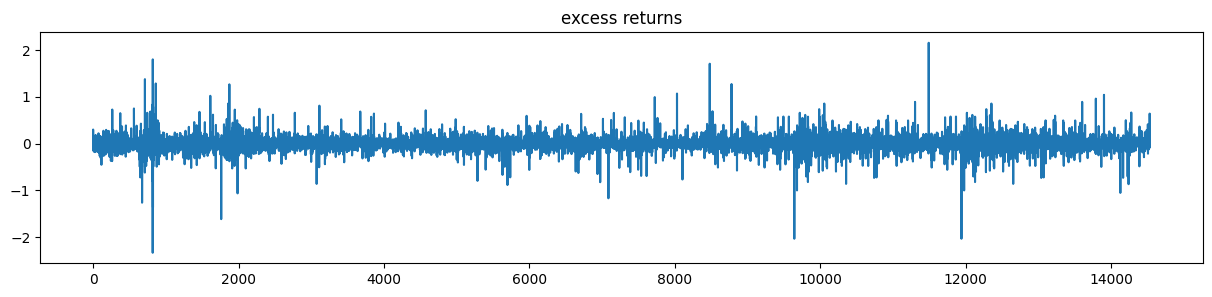

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

drive.mount('/content/drive', force_remount=True)

# Load the data
banknifty = pd.read_csv('/content/drive/My Drive/banknifty.csv', index_col=0)  # Adjust index_col appropriately


# Convert the TIMESTAMP column to datetime
banknifty['TIMESTAMP'] = pd.to_datetime(banknifty['TIMESTAMP'])  # Adjust the format if needed


# Set the TIMESTAMP as the index
banknifty=banknifty.drop(columns='DIR')
banknifty=banknifty.drop(columns='LABEL')

banknifty2 = banknifty.copy()

banknifty2.set_index('TIMESTAMP', inplace=True)

rows_per_period = 10

# Group by every 'rows_per_period' rows and use .nth(0) for the first and .nth(-1) for the last row in each group
banknifty_first = banknifty.groupby(banknifty.index // rows_per_period).nth(0)
banknifty_last = banknifty.groupby(banknifty.index // rows_per_period).nth(-1)

# Pre-allocate a list and then create the DataFrame from the list
percentage_changes = []

# Loop through data
for i in range(len(banknifty_first)):
    pct_change = ((banknifty_last.iloc[i]['CLOSE'] - banknifty_first.iloc[i]['CLOSE']) / banknifty_first.iloc[i]['CLOSE']) * 100
    percentage_changes.append(pct_change)

# Convert list to DataFrame
returns = pd.DataFrame(percentage_changes, columns=['Returns'])

# Display DataFrame
print(returns.head())
print(banknifty_first.head())

# Plot the results
# banknifty_ret['CLOSE'].iloc[:100].plot(title='excess returns', figsize=(15, 3), legend=False)
returns.plot(title='excess returns', figsize=(15, 3), legend=False)
# banknifty_ret.plot(title='excess returns', figsize=(15, 3), legend=False)


plt.show()

# banknifty




In [ ]:
#Run AD Fuller test; if P value is close to 0, the time series is relatively stationary and model can be fit on it
# adfuller(banknifty_ret.dropna()['CLOSE'])
adfuller(returns.dropna())

(-48.304281810697894,
 0.0,
 5,
 14526,
 {'1%': -3.4308002585680533,
  '5%': -2.861738994332033,
  '10%': -2.5668759199626456},
 -15821.107824295108)

In [ ]:
print(len(returns))

14532


In [ ]:
#Fit the model
mod_kns = sm.tsa.MarkovRegression(returns.dropna(), k_regimes=3, trend='n', switching_variance=True)

# mod_kns = sm.tsa.MarkovAutoregression(returns.dropna(), k_regimes=4, trend='n', switching_variance=True)


#https://www.statsmodels.org/devel/examples/notebooks/generated/markov_autoregression.html

res_kns = mod_kns.fit()
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                Returns   No. Observations:                14532
Model:               MarkovRegression   Log Likelihood               11466.009
Date:                Fri, 14 Jun 2024   AIC                         -22914.018
Time:                        05:51:56   BIC                         -22845.761
Sample:                             0   HQIC                        -22891.336
                              - 14532                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0036      0.000     23.914      0.000       0.003       0.004
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0163      0.001     20.394      0.000       0.015       0.018
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1964      0.016     11.983      0.000       0.164       0.229
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9075      0.008    117.919      0.000       0.892       0.923
p[1->0]        0.0917      0.010      9.257      0.000       0.072       0.111
p[2->0]        0.0163      0.032      0.515      0.607      -0.046       0.079
p[0->1]        0.0747      0.009      8.485      0.000       0.057       0.092
p[1->1]        0.8511      0.012     70.637      0.000       0.827       0.875
p[2->1]        0.6604      0.059     11.150      0.000       0.544       0.776
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [ ]:
# print(res_kns.smoothed_marginal_probabilities)
# print(banknifty_first['TIMESTAMP'])
# print(len(percentage_changes))


# Create an empty DataFrame
combined_data = pd.DataFrame()

# Add data to the DataFrame
combined_data['Timestamp'] = banknifty_first['TIMESTAMP']
combined_data['Low_Variance_Prob'] = res_kns.smoothed_marginal_probabilities[0].values
combined_data['Medium_Variance_Prob'] = res_kns.smoothed_marginal_probabilities[1].values
combined_data['High_Variance_Prob'] = res_kns.smoothed_marginal_probabilities[2].values
combined_data['Returns'] = percentage_changes  # 'percentage_changes' is a list of equal length

# print(combined_data.head())

daily_groups = combined_data.copy()
daily_groups['Timestamp'] = pd.to_datetime(combined_data['Timestamp'])

#Set the 'Timestamp' column as the DataFrame's index
combined_data.set_index('Timestamp', inplace=True)

print(combined_data)

#Split data into daily groups for charts
daily_groups = daily_groups.groupby(combined_data.index.date)

# daily_groups_df.set_index('Timestamp', inplace=True)

# print(daily_groups_df.columns)

                           Low_Variance_Prob  Medium_Variance_Prob  \
Timestamp                                                            
2023-01-02 09:16:00+05:30       1.018971e-01              0.841840   
2023-01-02 09:26:00+05:30       1.427422e-05              0.762038   
2023-01-02 09:36:00+05:30       6.682128e-03              0.918135   
2023-01-02 09:46:00+05:30       8.624369e-02              0.888150   
2023-01-02 09:56:00+05:30       1.784300e-01              0.805025   
...                                      ...                   ...   
2024-04-30 13:45:00+05:30       5.204571e-01              0.379946   
2024-04-30 13:55:00+05:30       2.141178e-22              0.000408   
2024-04-30 14:05:00+05:30       7.841090e-02              0.833846   
2024-04-30 14:15:00+05:30       2.879704e-01              0.694395   
2024-04-30 14:25:00+05:30       3.726557e-01              0.611851   

                           High_Variance_Prob   Returns  
Timestamp                      

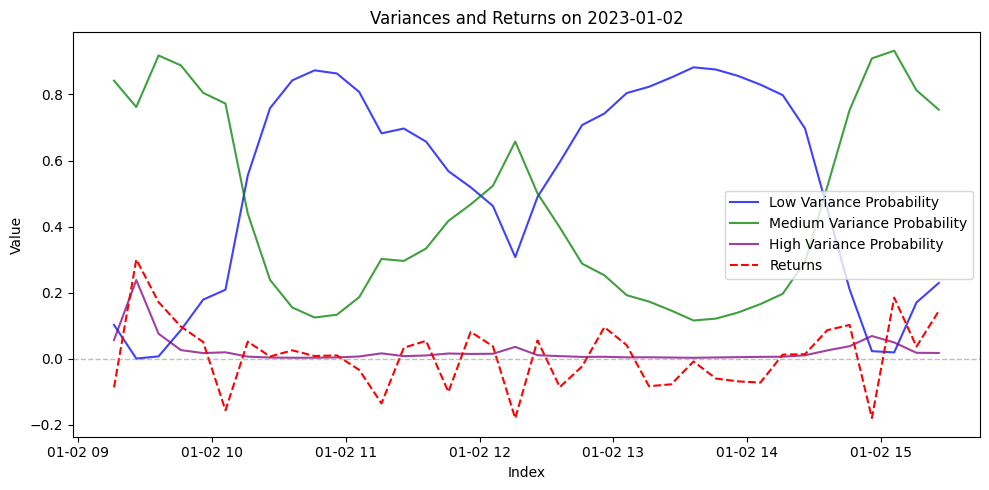

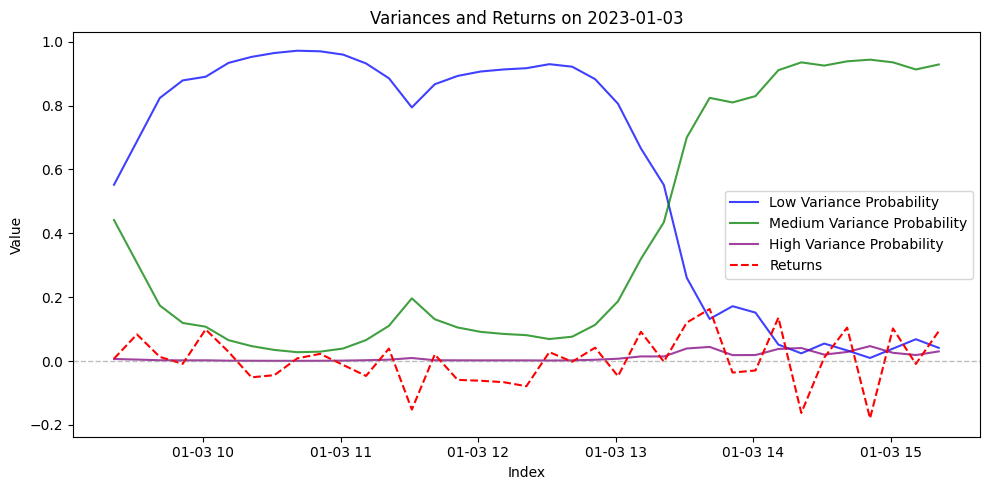

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Loop through each group and plot
for date, group in daily_groups:
    fig, ax = plt.subplots(figsize=(10, 5))
    titles = ['Low Variance Probability', 'Medium Variance Probability', 'High Variance Probability', 'Returns']
    data_keys = ['Low_Variance_Prob', 'Medium_Variance_Prob', 'High_Variance_Prob', 'Returns']
    colors = ['blue', 'green', 'purple', 'red']  # Colors for different data keys
    linestyles = ['-', '-', '-', '--']  # Line styles for different data keys
    alphas = [0.75, 0.75, 0.75, 1]  # Transparency levels

    for i, key in enumerate(data_keys):
        ax.plot(group['Timestamp'], group[key], label=titles[i], color=colors[i], linestyle=linestyles[i], alpha=alphas[i])

    # Adding a horizontal line at y=0
    ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

    ax.set_title(f'Variances and Returns on {date}')
    ax.legend()
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    plt.tight_layout()
    plt.show()

In [ ]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
med_var = list(res_kns.smoothed_marginal_probabilities[1])
high_var = list(res_kns.smoothed_marginal_probabilities[2])

regime_list = []
for i in range(len(low_var)):
    if low_var[i] > med_var[i] and low_var[i] > high_var[i]:
        regime_list.append(0)  # Low variance regime
    elif med_var[i] > high_var[i]:
        regime_list.append(1)  # Medium variance regime
    else:
        regime_list.append(2)  # High variance regime

# Iterate through banknifty close prices; color regimes based on whichever probability is highest.

combined_data['Regime_pred'] = regime_list
combined_data.head()

,Low_Variance_Prob,Medium_Variance_Prob,High_Variance_Prob,Returns,Regime_pred
Timestamp,,,,,
2023-01-02 09:16:00+05:30,0.101897,0.841840,0.056263,-0.087318,1
2023-01-02 09:26:00+05:30,0.000014,0.762038,0.237948,0.300101,1
2023-01-02 09:36:00+05:30,0.006682,0.918135,0.075183,0.170977,1
2023-01-02 09:46:00+05:30,0.086244,0.888150,0.025606,0.097033,1
2023-01-02 09:56:00+05:30,0.178430,0.805025,0.016545,0.050209,1


In [ ]:
banknifty2.head()
banknifty2.reset_index(inplace=True)
banknifty2.head()
# combined_data.head()

,TIMESTAMP,OPEN,HIGH,LOW,CLOSE
0,2023-01-02 09:16:00+05:30,43135.40,43151.25,43097.20,43118.30
1,2023-01-02 09:17:00+05:30,43116.50,43120.95,43071.55,43105.70
2,2023-01-02 09:18:00+05:30,43108.20,43108.60,43061.40,43077.45
3,2023-01-02 09:19:00+05:30,43076.55,43091.65,43030.05,43030.05
4,2023-01-02 09:20:00+05:30,43044.60,43069.45,42987.45,43056.05


In [ ]:
import pandas as pd

# Convert TIMESTAMP to datetime if not already done
banknifty2['TIMESTAMP'] = pd.to_datetime(banknifty2['TIMESTAMP'])

# Set time ranges
time_ranges = {
    'morning_session': ('09:15:00', '10:30:00'),
    'midday_session': ('10:31:00', '14:00:00'),
    'afternoon_session': ('14:01:00', '20:00:00')
}

# Filtering the data
morning_df = banknifty2[(banknifty2['TIMESTAMP'].dt.time >= pd.to_datetime(time_ranges['morning_session'][0]).time()) &
                        (banknifty2['TIMESTAMP'].dt.time <= pd.to_datetime(time_ranges['morning_session'][1]).time())]

midday_df = banknifty2[(banknifty2['TIMESTAMP'].dt.time >= pd.to_datetime(time_ranges['midday_session'][0]).time()) &
                       (banknifty2['TIMESTAMP'].dt.time <= pd.to_datetime(time_ranges['midday_session'][1]).time())]

afternoon_df = banknifty2[(banknifty2['TIMESTAMP'].dt.time >= pd.to_datetime(time_ranges['afternoon_session'][0]).time()) &
                          (banknifty2['TIMESTAMP'].dt.time <= pd.to_datetime(time_ranges['afternoon_session'][1]).time())]

# Now we have three dataframes: morning_df, midday_df, and afternoon_df
morning_df
midday_df
afternoon_df

,TIMESTAMP,OPEN,HIGH,LOW,CLOSE
285,2023-01-02 14:01:00+05:30,43128.30,43130.80,43116.80,43123.10
286,2023-01-02 14:02:00+05:30,43124.40,43124.40,43099.25,43102.75
287,2023-01-02 14:03:00+05:30,43101.75,43111.65,43084.70,43111.65
288,2023-01-02 14:04:00+05:30,43109.10,43114.75,43098.40,43108.75
289,2023-01-02 14:05:00+05:30,43108.85,43114.05,43098.25,43101.85
...,...,...,...,...,...
145315,2024-04-30 14:30:00+05:30,49934.60,49950.40,49926.15,49934.05
145316,2024-04-30 14:31:00+05:30,49931.45,49952.80,49924.95,49945.45
145317,2024-04-30 14:32:00+05:30,49941.10,49954.00,49913.25,49920.10
145318,2024-04-30 14:33:00+05:30,49918.30,49924.25,49855.80,49865.65


In [ ]:
#Calculate returns of 10 minute sets within each session
#Compare last 'x' amount of sets (lookback period is variable) and find std dev of the returns of all sets within this period
#Return a stddev column for each row in this 10 min period (std dev signifes the volatility of the 10 minute period that the row falls in, not each individual row's std dev within that 10 min period)
#i.e. Rows 0-9 will have a std dev value that represents the std dev of that entire 10 min period in comparison to its lookback period

# Compare the true std dev to predicted var by model

def calculate_returns(df, rows_per_period=10):
    # Reset the index to make sure it's numerical
    df.reset_index(drop=True, inplace=True)

    # Group by every 'rows_per_period' rows and use .nth(0) for the first and .nth(-1) for the last row in each group
    first = df.groupby(df.index // rows_per_period).nth(0)
    last = df.groupby(df.index // rows_per_period).nth(-1)

    # Pre-allocate a list and then create the DataFrame from the list
    percentage_changes = []

    # Loop through data
    for i in range(len(first)):
        pct_change = ((last.iloc[i]['CLOSE'] - first.iloc[i]['CLOSE']) / first.iloc[i]['CLOSE']) * 100
        percentage_changes.append(pct_change)

    # Convert series to DataFrame
    return pd.DataFrame(percentage_changes, columns=['Returns'])

# morning_df, midday_df, and afternoon_df are already defined
returns_morning = calculate_returns(morning_df)
returns_midday = calculate_returns(midday_df)
returns_afternoon = calculate_returns(afternoon_df)

# Display DataFrames
print("Morning Returns:\n", returns_morning.head())
print("Midday Returns:\n", returns_midday.head())
print("Afternoon Returns:\n", returns_afternoon.head())


Morning Returns:
     Returns
0 -0.087318
1  0.300101
2  0.170977
3  0.097033
4  0.050209
Midday Returns:
     Returns
0  0.100736
1 -0.116816
2  0.041345
3  0.147435
4 -0.149309
Afternoon Returns:
     Returns
0  0.066206
1 -0.200169
2  0.024960
3  0.015086
4  0.280944


In [ ]:
# Calculate rolling standard deviation over each 10-row period for each dataframe
#Here standard deviation and mean are of the last 'x' 10-minute periods of that session; lookback period is x (window=x).
#Testing x=30

rolling_std_dev_morning = returns_morning['Returns'].rolling(window=7).std()
rolling_std_dev_midday = returns_midday['Returns'].rolling(window=7).std()
rolling_std_dev_afternoon = returns_afternoon['Returns'].rolling(window=7).std()

rolling_mean_morning = returns_morning['Returns'].rolling(window=7).mean()
rolling_mean_midday = returns_midday['Returns'].rolling(window=7).mean()
rolling_mean_afternoon = returns_afternoon['Returns'].rolling(window=7).mean()

# Create new dataframes to hold the rolling standard deviation and mean values
returns_morning['Rolling Std Dev'] = rolling_std_dev_morning
returns_midday['Rolling Std Dev'] = rolling_std_dev_midday
returns_afternoon['Rolling Std Dev'] = rolling_std_dev_afternoon

returns_morning['Rolling Mean'] = rolling_mean_morning
returns_midday['Rolling Mean'] = rolling_mean_midday
returns_afternoon['Rolling Mean'] = rolling_mean_afternoon

# Display the dataframes with the rolling standard deviation
print("Rolling Standard Deviation for Morning Session:\n", returns_morning.dropna())
print("Rolling Standard Deviation for Midday Session:\n", returns_midday.dropna())
print("Rolling Standard Deviation for Afternoon Session:\n", returns_afternoon.dropna())

print(len(morning_df))
print(len(returns_morning))
print(len(rolling_std_dev_morning))

Rolling Standard Deviation for Morning Session:
        Returns  Rolling Std Dev  Rolling Mean
6     0.051323         0.152815      0.060820
7     0.045163         0.138989      0.079746
8    -0.052867         0.105783      0.029322
9     0.086462         0.090662      0.017248
10   -0.031010         0.084596     -0.001044
...        ...              ...           ...
2946  0.392963         0.546885      0.335022
2947 -0.313634         0.594126      0.282208
2948  0.085996         0.597439      0.271045
2949  0.066323         0.204776      0.059969
2950  0.000000         0.206053      0.052475

[2945 rows x 3 columns]
Rolling Standard Deviation for Midday Session:
        Returns  Rolling Std Dev  Rolling Mean
6     0.027626         0.115468     -0.007031
7    -0.028545         0.105244     -0.025499
8     0.006477         0.097443     -0.007886
9     0.053313         0.098549     -0.006176
10    0.005433         0.072949     -0.026462
...        ...              ...           ...
8133

In [ ]:
import numpy as np

def assign_variance_regime(df):
    # Initialize the new column for variance regime
    df['Variance Regime'] = None

    for index, row in df.iterrows():
        # Calculate the absolute deviation from the mean
        deviation = abs(row['Returns'] - row['Rolling Mean'])

        # Determine the variance regime based on the deviation and standard deviation
        if np.isnan(deviation):  # Check if the deviation is NaN
            df.loc[index, 'Variance Regime'] = '-1'
        elif deviation <= row['Rolling Std Dev']:
            df.loc[index, 'Variance Regime'] = '0'
        elif deviation <= 1.5 * row['Rolling Std Dev']:
            df.loc[index, 'Variance Regime'] = '1'
        else:
            df.loc[index, 'Variance Regime'] = '2'

    return df

# Apply the function to each returns DataFrame
returns_morning = assign_variance_regime(returns_morning)
returns_midday = assign_variance_regime(returns_midday)
returns_afternoon = assign_variance_regime(returns_afternoon)

# print("Updated Morning DataFrame with Variance Regimes:\n", returns_morning.dropna())
# print("Updated Midday DataFrame with Variance Regimes:\n", returns_midday[['Returns', 'Rolling Mean', 'Rolling Std Dev', 'Variance Regime']].dropna())
# print("Updated Afternoon DataFrame with Variance Regimes:\n", returns_afternoon[['Returns', 'Rolling Mean', 'Rolling Std Dev', 'Variance Regime']].dropna())

returns_morning

,Returns,Rolling Std Dev,Rolling Mean,Variance Regime
0,-0.087318,NaN,NaN,-1
1,0.300101,NaN,NaN,-1
2,0.170977,NaN,NaN,-1
3,0.097033,NaN,NaN,-1
4,0.050209,NaN,NaN,-1
...,...,...,...,...
2946,0.392963,0.546885,0.335022,0
2947,-0.313634,0.594126,0.282208,1
2948,0.085996,0.597439,0.271045,0
2949,0.066323,0.204776,0.059969,0


In [ ]:
# Create dictionaries for each session with indices and variance regimes
variance_regime_dict_morning = {index: row['Variance Regime'] for index, row in returns_morning.iterrows() if 'Variance Regime' in row}
variance_regime_dict_midday = {index: row['Variance Regime'] for index, row in returns_midday.iterrows() if 'Variance Regime' in row}
variance_regime_dict_afternoon = {index: row['Variance Regime'] for index, row in returns_afternoon.iterrows() if 'Variance Regime' in row}

# Display the dictionaries
print("Variance Regime Dictionary for Morning Session:", variance_regime_dict_morning)
print("Variance Regime Dictionary for Midday Session:", variance_regime_dict_midday)
print("Variance Regime Dictionary for Afternoon Session:", variance_regime_dict_afternoon)


Variance Regime Dictionary for Morning Session: {0: '-1', 1: '-1', 2: '-1', 3: '-1', 4: '-1', 5: '-1', 6: '0', 7: '0', 8: '0', 9: '0', 10: '0', 11: '0', 12: '1', 13: '0', 14: '0', 15: '2', 16: '0', 17: '2', 18: '0', 19: '0', 20: '0', 21: '0', 22: '1', 23: '0', 24: '0', 25: '1', 26: '0', 27: '0', 28: '1', 29: '0', 30: '2', 31: '0', 32: '0', 33: '0', 34: '0', 35: '0', 36: '0', 37: '0', 38: '0', 39: '2', 40: '0', 41: '0', 42: '0', 43: '0', 44: '0', 45: '1', 46: '1', 47: '0', 48: '0', 49: '0', 50: '1', 51: '1', 52: '0', 53: '2', 54: '0', 55: '0', 56: '0', 57: '0', 58: '0', 59: '0', 60: '0', 61: '1', 62: '0', 63: '0', 64: '0', 65: '1', 66: '0', 67: '1', 68: '0', 69: '2', 70: '0', 71: '0', 72: '0', 73: '0', 74: '1', 75: '2', 76: '0', 77: '0', 78: '0', 79: '0', 80: '0', 81: '0', 82: '0', 83: '2', 84: '0', 85: '0', 86: '0', 87: '0', 88: '0', 89: '0', 90: '1', 91: '1', 92: '0', 93: '2', 94: '0', 95: '0', 96: '0', 97: '0', 98: '0', 99: '1', 100: '1', 101: '0', 102: '0', 103: '0', 104: '0', 105: 

In [ ]:
#Assigning Variance Regime values to each individual minute row in each session dataframe. Note that (number of rows used per period of return) x (number of periods of lookback) rows will have -1 values in Variance Regimes,
# as they are below the threshold from which std dev and mean are calculated.
#rows_per_group must equal the number of minutes used for each distinct time set whose returns were calculated (not lookback period)

def assign_rolling_var_regime(df, variance_regime_dict, rows_per_group=10):
    df = df.copy()

    # Calculate group labels for each row in the dataframe
    group_labels = df.index // rows_per_group

    # Assign these labels as a column in the dataframe for merging purposes
    df.loc[:, 'Group'] = group_labels

    # Initialize the new column with NaN as a default value
    df['true_regime'] = np.nan

    # Loop through the dataframe and assign the regime where group matches
    for idx, row in df.iterrows():
        group_number = row['Group']
        if group_number in variance_regime_dict:
            df.loc[idx, 'true_regime'] = variance_regime_dict[group_number]

    return df

#returns_morning, returns_midday, returns_afternoon have been calculated as before
morning_df = assign_rolling_var_regime(morning_df, variance_regime_dict_morning)
midday_df = assign_rolling_var_regime(midday_df, variance_regime_dict_midday)
afternoon_df = assign_rolling_var_regime(afternoon_df, variance_regime_dict_afternoon)

# print(morning_df.tail(50))

In [ ]:
# Merge the three session DataFrames
merged_df = pd.concat([morning_df, midday_df, afternoon_df])

# Sort the merged DataFrame by timestamp
merged_df.sort_values(by='TIMESTAMP', inplace=True)

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

# merged_df['model_regime'] = combined_data['Regime_pred']
merged_df

,TIMESTAMP,OPEN,HIGH,LOW,CLOSE,Group,true_regime
0,2023-01-02 09:16:00+05:30,43135.40,43151.25,43097.20,43118.30,0,-1
1,2023-01-02 09:17:00+05:30,43116.50,43120.95,43071.55,43105.70,0,-1
2,2023-01-02 09:18:00+05:30,43108.20,43108.60,43061.40,43077.45,0,-1
3,2023-01-02 09:19:00+05:30,43076.55,43091.65,43030.05,43030.05,0,-1
4,2023-01-02 09:20:00+05:30,43044.60,43069.45,42987.45,43056.05,0,-1
...,...,...,...,...,...,...,...
145315,2024-04-30 14:30:00+05:30,49934.60,49950.40,49926.15,49934.05,3444,0
145316,2024-04-30 14:31:00+05:30,49931.45,49952.80,49924.95,49945.45,3444,0
145317,2024-04-30 14:32:00+05:30,49941.10,49954.00,49913.25,49920.10,3444,0
145318,2024-04-30 14:33:00+05:30,49918.30,49924.25,49855.80,49865.65,3444,0


In [ ]:
import numpy as np

#Repeating values by 10 since the model took 10 minute periods to calculate transition probabilities; not the same as lookback period
repeated_values = np.repeat(combined_data['Regime_pred'].values, 10)
merged_df['Regime_pred'] = repeated_values

merged_df['Regime_pred'] = pd.to_numeric(merged_df['Regime_pred'], errors='coerce')
merged_df['true_regime'] = pd.to_numeric(merged_df['true_regime'], errors='coerce')

merged_df.head(250)

,TIMESTAMP,OPEN,HIGH,LOW,CLOSE,Group,true_regime,Regime_pred
0,2023-01-02 09:16:00+05:30,43135.40,43151.25,43097.20,43118.30,0,-1,1
1,2023-01-02 09:17:00+05:30,43116.50,43120.95,43071.55,43105.70,0,-1,1
2,2023-01-02 09:18:00+05:30,43108.20,43108.60,43061.40,43077.45,0,-1,1
3,2023-01-02 09:19:00+05:30,43076.55,43091.65,43030.05,43030.05,0,-1,1
4,2023-01-02 09:20:00+05:30,43044.60,43069.45,42987.45,43056.05,0,-1,1
...,...,...,...,...,...,...,...,...
245,2023-01-02 13:21:00+05:30,43208.15,43213.55,43200.80,43210.75,17,0,0
246,2023-01-02 13:22:00+05:30,43200.20,43229.60,43200.20,43219.65,17,0,0
247,2023-01-02 13:23:00+05:30,43219.20,43220.50,43205.30,43215.35,17,0,0
248,2023-01-02 13:24:00+05:30,43214.00,43214.00,43201.00,43205.75,17,0,0


Confusion Matrix:


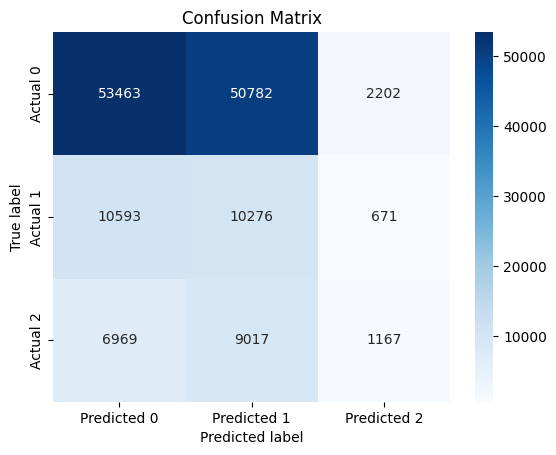

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#confusion matrix
labels = [0, 1, 2]
cm = confusion_matrix(merged_df['true_regime'], merged_df['Regime_pred'], labels=labels)

print("Confusion Matrix:")
# print(cm)

#plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2'], yticklabels=['Actual 0', 'Actual 1', 'Actual 2'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Catching Diwali Trading Hours
#  import pandas as pd

# df1 = banknifty2.copy()
# df2 = merged_df.copy()

# # Ensure both dataframes are sorted by timestamp
# df1.sort_values('TIMESTAMP', inplace=True)
# df2.sort_values('TIMESTAMP', inplace=True)

# # Use iterators to go through both dataframes
# i, j = 0, 0
# n1, n2 = len(df1), len(df2)

# # Loop through both DataFrames as long as we have data in both
# while i < n1 and j < n2:
#     ts1 = df1.iloc[i]['TIMESTAMP']
#     ts2 = df2.iloc[j]['TIMESTAMP']

#     if ts1 == ts2:
#         # If timestamps match, move to the next row in both DataFrames
#         i += 1
#         j += 1
#     else:
#         # If timestamps don't match, print the rows and advance the index of the earlier timestamp
#         print("Mismatch found:")
#         print("DataFrame 1 row:", df1.iloc[i])
#         print("DataFrame 2 row:", df2.iloc[j])

#         if ts1 < ts2:
#             i += 1
#         else:
#             j += 1

# # Check for any remaining rows if one DataFrame is longer
# while i < n1:
#     print("Remaining in DataFrame 1:", df1.iloc[i])
#     i += 1
# while j < n2:
#     print("Remaining in DataFrame 2:", df2.iloc[j])
#     j += 1


Mismatch found:
DataFrame 1 row: TIMESTAMP    2023-11-12 18:15:00+05:30
OPEN                           44054.5
HIGH                           44056.0
LOW                            43916.6
CLOSE                         43976.35
Name: 79861, dtype: object
DataFrame 2 row: TIMESTAMP      2023-11-13 09:15:00+05:30
OPEN                             43915.1
HIGH                             43934.6
LOW                              43828.6
CLOSE                            43846.7
Group                               1618
true_regime                            2
Name: 79861, dtype: object
Mismatch found:
DataFrame 1 row: TIMESTAMP    2023-11-12 18:16:00+05:30
OPEN                           43976.9
HIGH                           43989.1
LOW                           43965.95
CLOSE                         43979.55
Name: 79862, dtype: object
DataFrame 2 row: TIMESTAMP      2023-11-13 09:15:00+05:30
OPEN                             43915.1
HIGH                             43934.6
LOW                